In [34]:
!pip install -q -U pymysql sqlalchemy

In [19]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import pathlib
import getpass
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib as ptl
import pymysql
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots

In [20]:
mapassp = gpd.read_file(".//bases_de_dados//geojs-35-mun.json")
mapassp = mapassp[['id','name', "geometry"]]
mapassp

,id,name,geometry
0,3500105,Adamantina,"POLYGON ((-51.05787 -21.39888, -51.05365 -21.4..."
1,3500204,Adolfo,"POLYGON ((-49.65478 -21.20607, -49.63847 -21.2..."
2,3500303,Aguaí,"POLYGON ((-47.20890 -21.97129, -47.20297 -21.9..."
3,3500402,Águas da Prata,"POLYGON ((-46.70755 -21.82895, -46.70380 -21.8..."
4,3500501,Águas de Lindóia,"POLYGON ((-46.61147 -22.43496, -46.60302 -22.4..."
...,...,...,...
640,3557006,Votorantim,"POLYGON ((-47.37268 -23.51783, -47.37047 -23.5..."
641,3557105,Votuporanga,"POLYGON ((-50.02073 -20.33347, -50.01275 -20.3..."
642,3557154,Zacarias,"POLYGON ((-49.99521 -21.03253, -49.98434 -21.0..."
643,3557204,Chavantes,"POLYGON ((-49.68539 -22.94866, -49.68396 -22.9..."


## Índice de Nível Socieconômico

Para esta análise, usou-se uma tabela que contém dados que caracterizam brevemente a escola e, principalmente, dados do indicador socioeconômico da escola, o INSE. O indicador varia de 0 a 10, sendo 10 a escola com o nível socioeconômico mais baixo e 0 a escola com nível mais alto. O INSE é calculado a partir dos questionários do SARESP. Ele considera as seguintes variáveis: grau de escolaridade dos pais, posse de bens de consumo duráveis na residência e renda familiar.

Inicialmente, realizou-se a leitura da base com Geopandas e uma filtragem nos dados, para trabalhar somente com o necessário. Posteriormente, ainda, foram unidas as bases de dados com informações espaciais e do INSE do munícipio. 

In [21]:
sp_nse = gpd.read_file('.//bases_de_dados//escola_nse.csv')

#sp_nse = gpd.read_file("C://Users//vanes//OneDrive//Área de trabalho//arquivos bd//escola_nse.csv")

sp_nse = sp_nse[['id_municipio','nivel_socio_economico']]
sp_nse["nivel_socio_economico"] = pd.to_numeric(sp_nse["nivel_socio_economico"])

sp_nse.fillna(0, inplace = True)
sp_nse.rename(columns={"id_municipio": "id"}, inplace = 1)

sp_nse=sp_nse.groupby("id").mean()

sp_nse_f = mapassp.join(sp_nse, on="id", how="left")
sp_nse_f

,id,name,geometry,nivel_socio_economico
0,3500105,Adamantina,"POLYGON ((-51.05787 -21.39888, -51.05365 -21.4...",4.000000
1,3500204,Adolfo,"POLYGON ((-49.65478 -21.20607, -49.63847 -21.2...",4.190000
2,3500303,Aguaí,"POLYGON ((-47.20890 -21.97129, -47.20297 -21.9...",5.119091
3,3500402,Águas da Prata,"POLYGON ((-46.70755 -21.82895, -46.70380 -21.8...",5.600000
4,3500501,Águas de Lindóia,"POLYGON ((-46.61147 -22.43496, -46.60302 -22.4...",3.940000
...,...,...,...,...
640,3557006,Votorantim,"POLYGON ((-47.37268 -23.51783, -47.37047 -23.5...",4.268462
641,3557105,Votuporanga,"POLYGON ((-50.02073 -20.33347, -50.01275 -20.3...",4.268889
642,3557154,Zacarias,"POLYGON ((-49.99521 -21.03253, -49.98434 -21.0...",4.450000
643,3557204,Chavantes,"POLYGON ((-49.68539 -22.94866, -49.68396 -22.9...",5.020000


Na primeira plotagem, abaixo, é possível visualizar os nível socioeconômico (média das escolas) por município. 

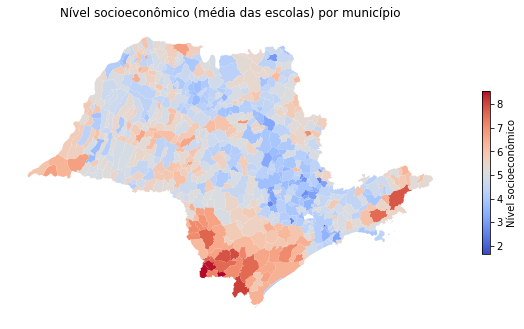

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
sp_nse_f.plot(ax=ax, column='nivel_socio_economico', cmap='coolwarm', legend=True,
                legend_kwds={'label': "Nível socioeconômico", 'shrink': 0.3} )
plt.title('Nível socioeconômico (média das escolas) por município') 
ax.axis('off');

Pelo mapa, é vísivel que alguns munícipios possuem níveis socioeconômicos (média das escolas) mais elevados que outros. O município com melhor índice de nível socioecônomico é águas de São Pedro (1.66), já com o pior INSE, é Itaóca (8.56), como verificado pelos gráficos de barras a seguir, que indicam os 10 melhores e 10 piores INSE. 

In [23]:
df = sp_nse_f[['name','nivel_socio_economico']] #tabela com os dados necessários
df1=df.sort_values('nivel_socio_economico', ascending=False).reset_index().head(10) #ordenação dos dados 
df2=df.sort_values('nivel_socio_economico').reset_index().head(10)

In [24]:
fig = px.bar(df1,
             x='name', y="nivel_socio_economico", height=500, width=700,
             barmode='stack', labels={"name": "Nome", 'nivel_socio_economico':"Nível socioeconômico "})
fig.update_layout(title = '10 municípios com piores níveis socioeconômicos (média das escolas)')
fig.update_xaxes(title = 'Município')
fig.update_yaxes(title = 'Nível socioeconômico médio das escolas')
fig.show()

In [25]:
fig = px.bar(df2,
             x='name', y="nivel_socio_economico", height=500, width=700,
             barmode='stack', labels={"name": "Nome", 'nivel_socio_economico':"Nível socioeconômico "})
fig.update_layout(title = '10 municípios com melhores nível socioeconômico (média das escolas)')
fig.update_xaxes(title = 'Município')
fig.update_yaxes(title = 'Nível socioeconômico médio das escolas')
fig.show()

##  Índice de Desenvolvimento da Educação do Estado de São Paulo

A tabela usada, nesse caso, contém dados da nota do Índice de Desenvolvimento da Educação do Estado de São Paulo (IDESP) para cada escola da rede estadual do estado de São Paulo, estabelecendo metas que as escolas devem alcançar ano a ano e seus resultados. Disponibilizada pela Secretaria de Educação do Estado de São Paulo, a tabela identifica cada escola através de códigos nacionais e estaduais e disponibiliza variáveis que demonstram para aquela dada escola, seu aproveitamento no IDESP. O IDESP é um indicador que avalia a qualidade da escola, sendo composto por dois critérios: o desempenho dos alunos nos exames de proficiência do SARESP (o quanto aprenderam) e o fluxo escolar (em quanto tempo aprenderam).Assim, nesta avaliação, considera–se que uma boa escola é aquela em que a maior parte dos alunos aprende as competências e habilidades requeridas para a sua série/ano, num período de tempo ideal – o ano letivo. 

Para a realização das análises, novamente realizou-se uma limpeza nos dados e selecionou-se o ano de 2018.

In [26]:
sp_idesp = gpd.read_file('.//bases_de_dados//escola_IDESP.csv')
sp_idesp = sp_idesp[["ano",'id_municipio','nota_idesp_ef_iniciais', "nota_idesp_ef_finais", "nota_idesp_em"]]
sp_idesp['nota_idesp_ef_iniciais'] = pd.to_numeric(sp_idesp["nota_idesp_ef_iniciais"])
sp_idesp['nota_idesp_ef_finais'] = pd.to_numeric(sp_idesp["nota_idesp_ef_finais"])
sp_idesp['nota_idesp_em'] = pd.to_numeric(sp_idesp["nota_idesp_em"])

sp_idesp.rename(columns={"id_municipio": "id"}, inplace = 1)

sp_idesp_2018_na = sp_idesp[sp_idesp["ano"] == "2018"]

sp_idesp_2018_na=sp_idesp_2018_na.groupby("id").mean()

sp_idesp_2018 = mapassp.join(sp_idesp_2018_na, on="id", how="left")

sp_idesp_2018.fillna(0, inplace = True)

sp_idesp_2018

,id,name,geometry,nota_idesp_ef_iniciais,nota_idesp_ef_finais,nota_idesp_em
0,3500105,Adamantina,"POLYGON ((-51.05787 -21.39888, -51.05365 -21.4...",0.00,3.423333,2.250000
1,3500204,Adolfo,"POLYGON ((-49.65478 -21.20607, -49.63847 -21.2...",0.00,0.000000,3.170000
2,3500303,Aguaí,"POLYGON ((-47.20890 -21.97129, -47.20297 -21.9...",6.70,2.943333,2.436667
3,3500402,Águas da Prata,"POLYGON ((-46.70755 -21.82895, -46.70380 -21.8...",0.00,4.250000,3.110000
4,3500501,Águas de Lindóia,"POLYGON ((-46.61147 -22.43496, -46.60302 -22.4...",6.97,3.650000,3.630000
...,...,...,...,...,...,...
640,3557006,Votorantim,"POLYGON ((-47.37268 -23.51783, -47.37047 -23.5...",0.00,3.728462,2.754615
641,3557105,Votuporanga,"POLYGON ((-50.02073 -20.33347, -50.01275 -20.3...",0.00,3.665556,2.413750
642,3557154,Zacarias,"POLYGON ((-49.99521 -21.03253, -49.98434 -21.0...",0.00,2.800000,2.650000
643,3557204,Chavantes,"POLYGON ((-49.68539 -22.94866, -49.68396 -22.9...",0.00,2.620000,2.560000


No mapas a seguir, pode-se visualizar, inicialmente, que as escolas estaduais no estado de São Paulo, em geral, abordam o Ensino Médio, já as séries iniciais possuem muitos valores vazios por município, ou seja, não possuem avaliação do IDESP pois, provavelmente, são escolas municipais que fornecem esse nível de educação.

Ainda, até 2030, a meta é que as escolas alcancem índice 7 para o ciclo que vai do 1° ao 5° ano, índice 6 para o ciclo que vai do 6° ao 9° ano e índice 5 para o Ensino Médio. Pelas plotagens, a séries iniciais parecem estar mais próximas do objetivo, mesmo que tenham que alcançar notas mais altas.

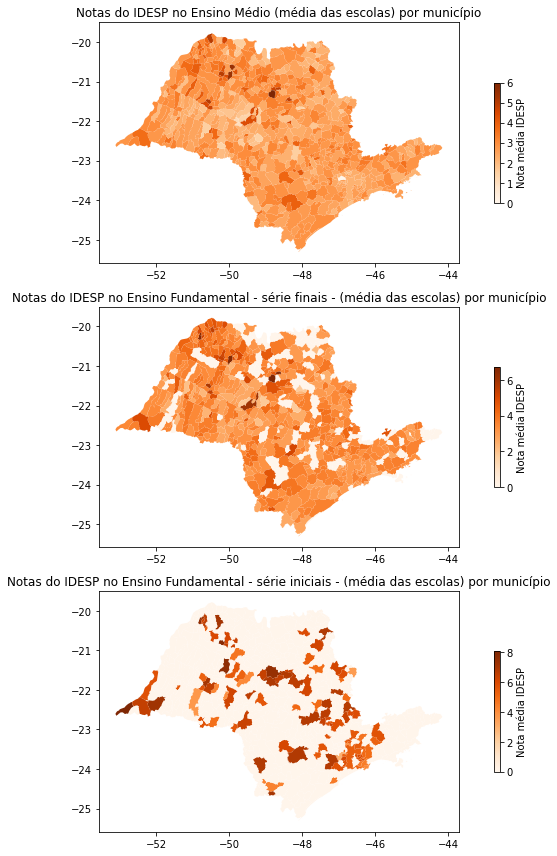

In [27]:
fig, axs = plt.subplots(3, figsize=(10, 12))

sp_idesp_2018.plot(ax=axs[0], column='nota_idesp_em', cmap='Oranges', legend=True, legend_kwds={'label': "Nota média IDESP", 'shrink': 0.5})
axs[0].set_title('Notas do IDESP no Ensino Médio (média das escolas) por município')

sp_idesp_2018.plot(ax=axs[1], column='nota_idesp_ef_finais', cmap='Oranges', legend=True, legend_kwds={'label': "Nota média IDESP", 'shrink': 0.5})
axs[1].set_title('Notas do IDESP no Ensino Fundamental - série finais - (média das escolas) por município')

sp_idesp_2018.plot(ax=axs[2], column='nota_idesp_ef_iniciais', cmap='Oranges', legend=True, legend_kwds={'label': "Nota média IDESP", 'shrink': 0.5})
axs[2].set_title('Notas do IDESP no Ensino Fundamental - série iniciais - (média das escolas) por município')

plt.tight_layout();

In [28]:
media_efi=sp_idesp_2018_na['nota_idesp_ef_iniciais'].dropna().mean()
media_eff=sp_idesp_2018_na['nota_idesp_ef_finais'].dropna().mean()
media_em=sp_idesp_2018_na['nota_idesp_em'].dropna().mean()

print ("Média IDESP para as séries iniciais:",media_efi)
print ("Média IDESP para as séries finais:",media_eff)
print ("Média IDESP para o Ensino Médio:",media_em)

Média IDESP para as séries iniciais: 5.816202782521359
Média IDESP para as séries finais: 3.508004797976173
Média IDESP para o Ensino Médio: 2.781134240115724


Com as médias calculadas, observa-se que, realmente,  as séries iniciais, pela média, estão mais próximas de alcançar o objetivo. Contudo, existem munícipios que já alcançaram-no, como verificado pelas tabelas abaixo.

In [29]:
obj_efi=sp_idesp_2018[sp_idesp_2018["nota_idesp_ef_iniciais"] >= 7]
print("Munícipio que já atingiram a meta para séries iniciais (analisando a média):")
obj_efi[['name', "nota_idesp_ef_iniciais"]].sort_values('nota_idesp_ef_iniciais', ascending=False)

Munícipio que já atingiram a meta para séries iniciais (analisando a média):


,name,nota_idesp_ef_iniciais
496,Rosana,8.035
191,Gastão Vidigal,7.800
420,Penápolis,7.640
527,Santana da Ponte Pensa,7.560
260,Itápolis,7.430
339,Mirante do Paranapanema,7.170
177,Fernandópolis,7.090
219,Iacri,7.030
253,Itaóca,7.010


In [30]:
obj_efi=sp_idesp_2018[sp_idesp_2018["nota_idesp_ef_finais"] >= 6]
print("Munícipio que já atingiram a meta para séries finais (analisando a média):")
obj_efi[['name', "nota_idesp_ef_finais"]].sort_values('nota_idesp_ef_finais', ascending=False)

Munícipio que já atingiram a meta para séries finais (analisando a média):


,name,nota_idesp_ef_finais
511,Santa Adélia,6.72
316,Macaubal,6.59
527,Santana da Ponte Pensa,6.53
638,Vista Alegre do Alto,6.51
435,Pirajuí,6.00


In [31]:
obj_efi=sp_idesp_2018[sp_idesp_2018["nota_idesp_em"] >= 5]
print("Munícipio que já atingiram a meta para o Ensino Médio (analisando a média):")
obj_efi[['name', "nota_idesp_em"]].sort_values('nota_idesp_em', ascending=False)

Munícipio que já atingiram a meta para o Ensino Médio (analisando a média):


,name,nota_idesp_em
511,Santa Adélia,6.00
316,Macaubal,5.46
572,Sebastianópolis do Sul,5.42
188,Gabriel Monteiro,5.00


## Segurança no Estado de São Paulo

Nesse caso, usou-se uma base de dados com informações mensais das ocorrências registradas pela Secretaria de Segurança Publica de São Paulo (SSP). Fez-se a limpeza de dados e acrescentamos uma coluna de ocorrências totais com os dados que supomos relevantes.

In [32]:
df_seguranca = pd.read_csv(".//bases_de_dados//ocorrencias_registradas.csv")

mapassp["id"]=mapassp["id"].astype(int)

df_seguranca.rename(columns={"id_municipio": "id"}, inplace = 1)

df_seguranca_2018 = df_seguranca[df_seguranca["ano"] == 2018]

df_seguranca_2018 = df_seguranca_2018.groupby("id").sum()


df_seguranca_2018= mapassp.join(df_seguranca_2018,on="id", how="left")
df_seguranca_2018

df_seguranca_2018["total"]=df_seguranca_2018["homicidio_doloso"]+df_seguranca_2018["homicidio_culposo_por_acidente_de_transito"]+df_seguranca_2018["homicidio_culposo_outros"]+df_seguranca_2018["tentativa_de_homicidio"]+df_seguranca_2018["lesao_corporal_seguida_de_morte"]+df_seguranca_2018["lesao_corporal_dolosa"]+df_seguranca_2018["lesao_corporal_culposa_outras"]+df_seguranca_2018["homicidio_doloso"]+df_seguranca_2018["latrocinio"]+df_seguranca_2018["total_de_estupro"]+df_seguranca_2018["roubo_outros"]+df_seguranca_2018["roubo_de_veiculo"]+df_seguranca_2018["roubo_a_banco"]+df_seguranca_2018["roubo_de_carga"]+df_seguranca_2018["roubo_de_carga"]+df_seguranca_2018["furto_outros"]+df_seguranca_2018["furto_de_veiculo"]

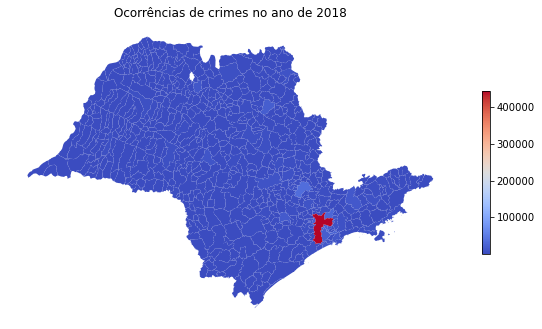

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
df_seguranca_2018.plot(ax=ax, column='total', cmap='coolwarm', legend=True, legend_kwds={'shrink': 0.3})
plt.title('Ocorrências de crimes no ano de 2018') 
ax.axis('off');

Na plotagem do mapa do estado com as ocorrências totais, é evidente o quanto São Paulo se destaca com um número de casos bastante elevado em relação aos outros municípios. Já Torre de Pedra é o município com o menor número de ocorrência, apenas 6.

In [34]:
menores_ocor=df_seguranca_2018.sort_values('total').reset_index().head(10)
menores_ocor[["name", "total"]]

,name,total
0,Torre de Pedra,6.0
1,Dirce Reis,7.0
2,Aspásia,9.0
3,Santa Salete,10.0
4,Arco-Íris,11.0
5,Marinópolis,12.0
6,Vitória Brasil,13.0
7,Trabiju,14.0
8,Paulistânia,14.0
9,Borá,15.0


## IDESP e INSE

In [35]:
IDESP_INSE=sp_nse.join(sp_idesp_2018_na, on="id", how="left")
IDESP_INSE

,nivel_socio_economico,nota_idesp_ef_iniciais,nota_idesp_ef_finais,nota_idesp_em
id,,,,
3500105,4.000000,NaN,3.423333,2.250000
3500204,4.190000,NaN,NaN,3.170000
3500303,5.119091,6.70,2.943333,2.436667
3500402,5.600000,NaN,4.250000,3.110000
3500501,3.940000,6.97,3.650000,3.630000
...,...,...,...,...
3557006,4.268462,NaN,3.728462,2.754615
3557105,4.268889,NaN,3.665556,2.413750
3557154,4.450000,NaN,2.800000,2.650000


In [38]:
fig=px.scatter(IDESP_INSE, x = "nivel_socio_economico", y = "nota_idesp_em")
fig.update_traces(marker=dict(size = 8,line = dict(width = 2)),selector=dict(mode = 'markers'))
fig.update_layout(title = 'IDESP X INSE')
fig.update_xaxes(title = 'Notas IDESP - Ensino Médio')
fig.update_yaxes(title = 'índice de nível socioeconômico')
fig.show()